<a href="https://colab.research.google.com/github/pranshudatascience/Concrete-Structural-Defects-Dataset/blob/main/Concrete_Structural_Defects_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# **Uploading Data via Kaggle Api**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aniruddhsharma/structural-defects-network-concrete-crack-images

 97% 489M/506M [00:04<00:00, 118MB/s]
100% 506M/506M [00:04<00:00, 122MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "structural-defects-network-concrete-crack-images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#Give dataset path
train_path = '/content/DATA'
#test_path = '/content/validation'

In [ ]:
folders = glob('/content/DATA/*')
len(folders)

6

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Designing Our Model**

In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=7, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

# **Image Augmentation**

In [ ]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)  # val 20%

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#no flip and zoom for test dataset

In [ ]:
# Make sure you provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory('/content/DATA',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

Found 44875 images belonging to 7 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/DATA',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'validation')

Found 11217 images belonging to 7 classes.


# **Training Our Model**

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
1403/1403 [==============================] - 632s 450ms/step - loss: 0.3660 - accuracy: 0.8763 - val_loss: 0.4408 - val_accuracy: 0.8455
Epoch 2/4
1403/1403 [==============================] - 628s 448ms/step - loss: 0.3618 - accuracy: 0.8798 - val_loss: 0.3907 - val_accuracy: 0.8639
Epoch 3/4
1403/1403 [==============================] - 622s 443ms/step - loss: 0.3539 - accuracy: 0.8803 - val_loss: 0.3705 - val_accuracy: 0.8815
Epoch 4/4
1403/1403 [==============================] - 619s 441ms/step - loss: 0.3515 - accuracy: 0.8826 - val_loss: 0.3879 - val_accuracy: 0.8694


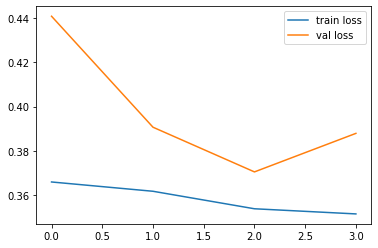

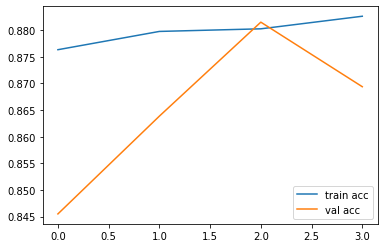

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('modelconcrete.h5')

# **Making Predictions**

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, r2_score
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 4, 5, ..., 5, 4, 4])

In [ ]:
classes = [" The Given Image is of The Cracked Deck !!! ",  " The Given Image is of The Cracked Pavements !!!" ,  " The Given Image is of The Cracked Walls!!! ", " The Given Image is of The  Non-Cracked Deck !!! ", "The Given Image is of The  Non-Cracked Pavements !!!", " The Given Image is of The  Non-Cracked Walls !!!"]

In [ ]:
def predict_image(img):
    plt.figure(figsize=(40,8))
    print()
    print('-----------------------------------------Concrete Cracks Image Dataset-----------------------------------------')
    print()
    print('-----------------------------------------Result----------------------------------------------------------------')
    print()
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img)
    x=np.expand_dims(x,axis=0)
    #img_data=preprocess_input(x)

    print(classes[np.argmax(model.predict(x))])


-----------------------------------------Concrete Cracks Image Dataset-----------------------------------------

-----------------------------------------Result----------------------------------------------------------------

The Given Image is of The  Non-Cracked Pavements !!!


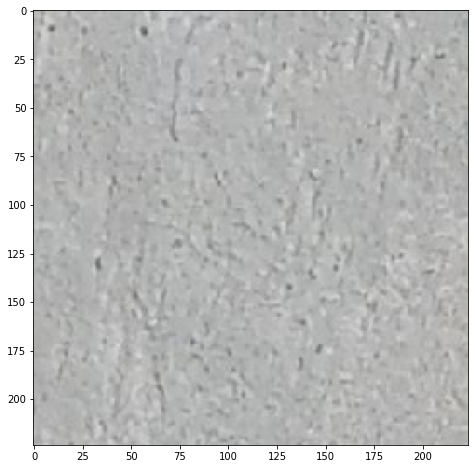

In [ ]:
im=image.load_img('/content/DATA/Cracked Decks/7001-115.jpg',target_size=(224,224))
predict_image(im)


-----------------------------------------Concrete Cracks Image Dataset-----------------------------------------

-----------------------------------------Result----------------------------------------------------------------

 The Given Image is of The  Non-Cracked Walls !!!


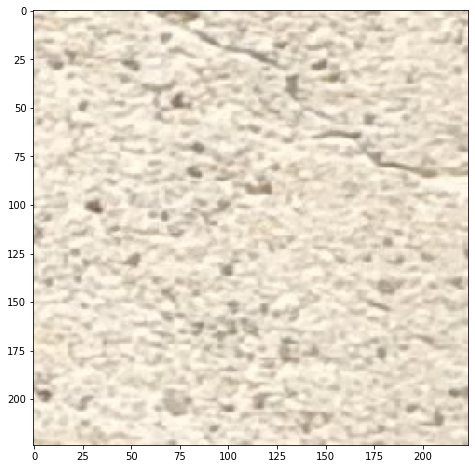

In [ ]:
im2=image.load_img('/content/DATA/Cracked Pavements/001-125.jpg',target_size=(224,224))
predict_image(im2)


-----------------------------------------Concrete Cracks Image Dataset-----------------------------------------

-----------------------------------------Result----------------------------------------------------------------

The Given Image is of The  Non-Cracked Pavements !!!


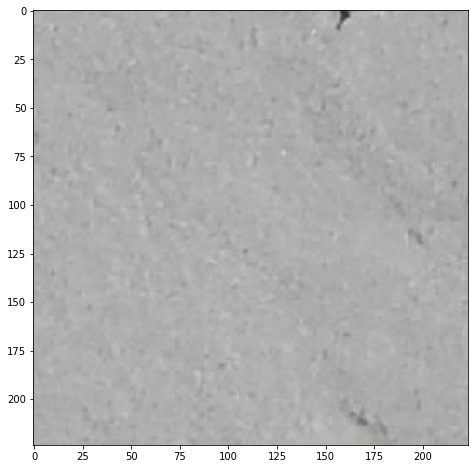

In [ ]:
im4=image.load_img('/content/DATA/Non-cracked Decks/7001-102.jpg',target_size=(224,224))
predict_image(im4)


-----------------------------------------Concrete Cracks Image Dataset-----------------------------------------

-----------------------------------------Result----------------------------------------------------------------

 The Given Image is of The  Non-Cracked Walls !!!


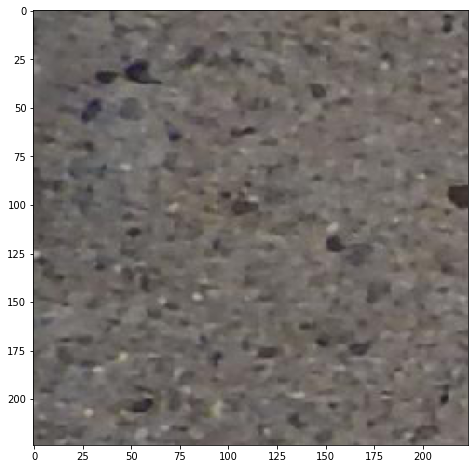

In [ ]:
im5=image.load_img('/content/DATA/Non-cracked Pavements/001-109.jpg',target_size=(224,224))
predict_image(im5)